# Vícevrstvé sítě a zpětná propagace

V tomto cvičení si vyzkoušíme klasifikaci pomocí vícevrstvých dopředných sítí, tzv. vícevrstvých perceptronů. Pro porovnání se přitom zaměříme na stejný dataset jako minule, tedy klasifikaci koček.

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from IPython.core.debugger import set_trace

plt.rcParams['figure.figsize'] = (12., 8.)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Načtení dat

### Trénovací a validační množiny

In [102]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

X_all = np.zeros((50000, 32, 32, 3), dtype=np.uint8)
y_all = np.zeros(50000, dtype=np.int32)

for i in range(5):
    batch_file = 'data/cifar-10-batches-py/data_batch_' + str(i + 1)
    with open(batch_file, 'rb') as f:
        data = pickle.load(f, encoding='latin1')
        X_all[10000 * i:10000 * (i+1)] = data['data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        y_all[10000 * i:10000 * (i+1)] = data['labels']

num_train, num_valid = 40000, 10000
X_train, y_train = X_all[:num_train], y_all[:num_train]
X_valid, y_valid = X_all[num_train:], y_all[num_train:]

x_dim = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]

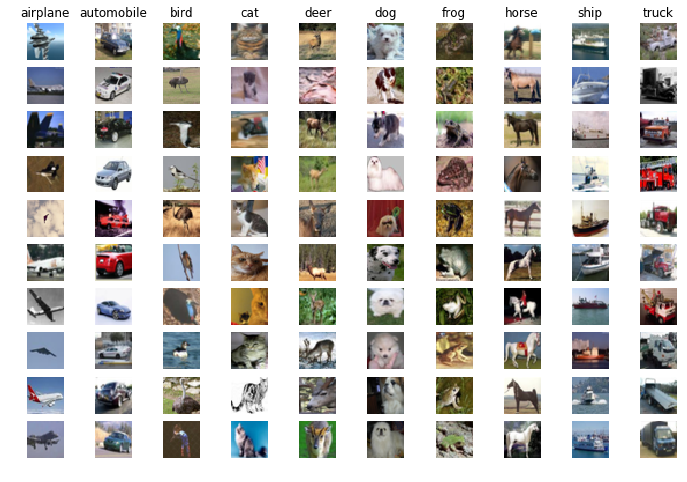

In [103]:
for i, cls in enumerate(classes):
    cls_ids, = np.where(y_train == i)
    draw_ids = np.random.choice(cls_ids, size=10)
    
    for j, k in enumerate(draw_ids):
        plt.subplot(10, 10, j * 10 + i + 1)
        plt.imshow(X_train[k])
        plt.axis('off')
        if j == 0:
            plt.title(cls)
plt.show()

## Pomocné funkce

Jelikož budeme pracovat s dávkami, nikoliv jednotlivými vektory, přizpůsobíme tomu všechny funkce, včetně těch pomocných jako je např. `preprocess`.

In [104]:
def preprocess(rgb_batch):
    """
    funkce odecte prumernou hodnotu pixelu pro kazdy kanal
    
    vstup:
        rgb_batch ... N x H x W x C matice davky vstupnich obrazku
    
    vystup:
        out ... N x H x W x C matice davky upravenych obrazku
    """
    # prevedeni do rozsahu 0..1
    out = rgb_batch / 255.
    
    # prumer pres jednotlive kanaly pro kazdy obrazek --> `m` bude matice N x C
    m = np.mean(out, axis=(1, 2))
    
    # abychom mohli odecist broadcastingem, pridame do `m` dve dimenze
    out -= m[:, None, None, :]
    
    return out

In [105]:
def plot_history(loss, acc=None, avg_range=0):
    """
    vykresli prubeh lossu a prip. do stejneho grafu zakresli i prubeh acc
    avg_range ... prumeruj hodnoty po tomto poctu (napr. po 10)
    """
    if avg_range > 0:
        div = avg_range * (len(loss) // avg_range)
        loss = np.mean(np.reshape(loss[:div], (-1, avg_range)), axis=1)
    
    fig, ax1 = plt.subplots()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    ax1.plot(loss, color=colors[0])
    ax1.set_ylabel('loss')

    if acc is not None:
        if avg_range > 0:
            acc = np.mean(np.reshape(acc[:div], (-1, avg_range)), axis=1)
        ax2 = ax1.twinx()
        ax2.plot(acc, color=colors[1])
        ax2.set_ylabel('acc')

    fig.tight_layout()
    plt.show()

## Lineární klasifikátor modulárně

Základním kamenem lineární klasifikace je lineární, či technicky vzato správně afinní, operace $z=Wx+b$. Z uvedeného vztahu se pak odvozuje podoba gradientu na váhy
$$\frac{\partial L}{\partial W} = \frac{\partial L}{\partial z}x^\top$$
Jak jsme si ukázali v přednášce, vyjádřením této operace jako vrstvy s dopředným a zpětným průchodem je možné výpočty libovolně řetězit a kombinovat, což usnadňuje sestavení vícevrstvých hlubokých sítí. 

Jako první tedy modularizujeme lineární vrstvu, tj. zadefinujeme dvě metody, jednu pro dopředný průchod a druhou pro zpětný.
1. Dopředný průchod vrátí $z$ dle výše uvedeného vzorce a pro efektivní výpočty uloží některé proměnné do paměti.
2. Zpětný průchod přijme nějaký příchozí gradient (např. z nadřazené vrstvy či lossu), spočítá gradienty na svoje parametry $W$ a $b$ a vstup $x$ a vrátí k případné další propagaci výpočetním grafem.

*Pozn.:* Všechny funkce navrhneme tak, aby pracovaly s dávkami vzorků (mini-batch), nikoliv pro samostatné vektory. Změna se projeví pouze tak, že se gradienty pro každý vzorek sečtou. Pokud např. $z_1=Wx_1 + b$ a $z_2=Wx_2 + b$, tj. mezi oběma výpočty se nezměnily hodnoty $W$ a $b$, pak gradient $$\frac{\partial L}{\partial W} = \frac{\partial L}{\partial z_1}x_1^\top + \frac{\partial L}{\partial z_2}x_2^\top$$

In [106]:
class Layer(object):
    def __init__(self):
        self.params = {}
        self._cache = None
    
    def forward(self, x):
        return x
    
    def backward(self, dout):
        return dout, {}

In [107]:
class Dense(Layer):
    def __init__(self, input_dim, output_dim, init_coef=1e-3):
        """
        Linearni (afinni) vrstva
        
        parametry:
            w ... matice vah
            b ... bias vektor
        
        vstup:
            input_dim ... rozmer vstupnich dat
            output_dim ... rozmer vystupniho linearniho skore
            init_coef ... std. ochylka pro inicicializaci vah
        """
        super().__init__()
        
        self.params = {
            'w': init_coef * np.random.randn(input_dim, output_dim),
            'b': np.zeros(output_dim),
        }
    
    def forward(self, x):
        """
        dopredny pruchod linearni vrstvou

        vstup:
            x ... N x D matice vstupu

        vystup:
            s ... N x H vystupni linearni skore
        """
        
        w = self.params['w']
        b = self.params['b']
        
        #################################################################
        # ZDE DOPLNIT
        #################################################################
        s = np.dot(x, w) + b 
        
        self._cache = x ,w
        
        return s
    
    def backward(self, ds):
        """
        zpetny pruchod linearni vrstvou

        vstup:
            ds ... N x H prichozi gradient z nadrazene vrstvy

        vystup:
            dx    ... N x D gradient na vstup
            grads ... slovnik mapujici jmena parametru na jejich gradienty
        """
        
        #################################################################
        # ZDE DOPLNIT
        #################################################################
        x, w = self._cache
        w = self.params['w'] 
        dx = np.dot(ds,w.T)
        dw = np.dot(x.T,ds)
        db = np.sum(ds, axis=0)

        return dx, {'w': dw, 'b': db}

### Gradient check

Abychom si ověřili, že obě funkce dělají stkuečně to, co mají, porovnáme vypočtené gradienty se "skutečnými" hodnotami zjištěnými numerickou diferencí. Ta nevyužívá žádné vzorce, pouze zkoumá, jak se výstup mění v závislosti na malých změnách jednotlivých vstupů.

In [108]:
def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Prevzato z Standford cs231n.
    
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad

In [109]:
def check_gradients(model, x, dout):
    """
    Funkce vyzkousi dopredny a zpetny pruchod pro kazdy parametr zadaneho modelu
    a zkontroluje gradienty vuci numericke diferenci
    
    model ... objekt tridy Layer; musi implementovat metody forward, forward_func, backward, backward_func
    x ... N x D vstupni matice dat
    dout ... matice N x H gradientu na vystup site
    """
    
    # vypocti gradienty analyticky (potencialne s bugy)
    out = model.forward(x)
    dx, grads = model.backward(dout)
    
    # numericky gradient (diference) na vstup (je vzdy az na toleranci spravne)
    dx_num = eval_numerical_gradient_array(model.forward, x, dout)
    print('dx error: ', rel_error(dx, dx_num))
    
    # numericky gradient na parametry modelu
    for name in model.params:
        dp_num = eval_numerical_gradient_array(lambda p: model.forward(x), model.params[name], dout)
        print('d{} error: '.format(name), rel_error(grads[name], dp_num))

In [110]:
def rel_error(x, y):
    """
    Prevzato z Standford cs231n.
    
    returns relative error
    """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [112]:
# zkusebni instance modelu
dense_layer = Dense(5, 3)

# toy vstupni data
x = np.random.randn(10, 5)

# "simulace" gradientu na vystup
dout = np.random.randn(10, 3)

# porovnani; rel. chyba gradientu by mela byt velmi mala, radove 1e-10
check_gradients(dense_layer, x, dout)

dx error:  2.532817443868773e-10
dw error:  3.5753347183747284e-14
db error:  1.663391082128781e-14


## Softmax cross entropy

Kritérium je svým způsobem "terminální" vrstva, kde výpočet končí. Hodnota lossu určí, jak moc je výstup ze sítě (vstup do lossu) špatný porovnáním se správnou hodnotou. Druhým krokem je vrátit gradient na svůj vstup (tedy výstup sítě), který říká, co a jak změnit. Jak si tento gradient síť dále přebere a propaguje, už "je její starost". Koncepčním rozdílem oproti vnitřním vrstvám sítě je, že loss nepříjímá žádný gradient "svrchu" a nedělí se na dopředný a zpětný průchod - vše je v jednom.

Výstup logistické regrese je definován jako
$$p_c = \frac{\exp{s_c}}{\sum_{i=0}^{C-1}\exp{s_i}}$$

kde $s_c = w_c^\top x$ je lineární skóre, $w_c$ je $c$-tý řádek matice vah $W$. Pravděpodobnosti $p_c$ pak vstupují do křížové entropie, která je porovná se správným rozložením (samé nuly kromě jedné jedničky pro správnou třídu) dle vztahu
$$L = -\sum_{c=0}^{C-1}\left(\boldsymbol{1}(c=y)\log p_c\right) = -\log p_y$$

Jelikož je softmax monotónní operace, neboli pořadí prvků dle jejich velikosti se po provedení nemění, nění $p_c$ v praxi potřeba počítat. Pokud bude např. $s_2 = w_c^\top x > s_5 = w_c^\top x$, pak i $p_2 > p_5$, a tak můžeme predikovat už na základě skóre $s = Wx + b$ zjištením prvku s max. hodnotou.

Loss funkci proto zadefinujeme tak, že softmax bude její součástí. Výhodou tohoto přístupu navíc je, že budeme moci snadno vyměnit loss např. za SVM hinge, které rovněž přijímá skóre, nikoliv pravděpodobnosti. Zpětný průchod, neboli gradient na vektor skóre $s$ je
$$\frac{\partial L}{\partial s_c} = \log p_c - \boldsymbol{1}(c=y)$$

In [179]:
def softmax_cross_entropy(score, y, average=True):
    """
    spocita softmax krizovou entropii pro vstupni skore a spravne tridy y
    
    vstup:
        score ... N x H matice skore, n-ty radek je skore pro n-ty obrazek
        y ... int vektor o rozmeru N, kde n-ty prvek znaci index spravne tridy n-teho obrazku
        average ... pokud True, pak vydeli loss poctem vzorku (zprumeruje)
    
    vystup:
        loss ... hodnota lossu
        dscore ... N x H matice gradientu na vstup
    """
    
    #################################################################
    # ZDE DOPLNIT
    #################################################################\
    
    # nejsem kamarad s numpy. Uprednostnuju klasicky postup  
    prob = np.zeros(score.shape)
    loss = np.zeros(score.shape[0])
    for i in range(0, score.shape[0]):
        for j in range(0, score.shape[1]):
            prob[i, j ] = np.exp(score[i, j])/sum(np.exp(score[i, :]))
            if j == y[i]:
                loss[i] = -np.log(prob[i, j ])
                prob[i, j ] -= 1
                
                
    
    if average:
        loss /= score.shape[0]
    
    dscore = prob.copy()
    dscore[range(score.shape[0]), y] -= 1.
    
    return loss, dscore

### Inicializace

In [114]:
x_dim = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]
softmax_model = Dense(x_dim, len(classes))

loss_history = []
l2_history = []
acc_history = []

### Trénování

Jak jsme si ukázali v prvním cvičení, nejrozšířenějším způsobem učení neuronových sítí je iterativní minimimalizace metodou stochastic gradient descent (SGD). Po malých dávkách síť vždy predikuje výstup, ten se nějakým kritériem (loss) porovná se správnou hodnotou (ground truth) a na základě tohoto rozdílu se upraví vnitřní parametry modelu tak, aby příště výstup co možná nejlépe odpovídal anotaci. Neustále se tedy opakuje:
1. navzorkování dávky dat (minibatch)
2. dopedný průchod (výstupní skóre)
3. vyhocení kritéria (loss)
3. zpětný průchod (gradient na parametry)
4. update parametrů

Jelikož trénování téměř libovolného dopředného modelu pro klasifikaci lze provést tímto způsobem, zabalíme celý proces do metody, které vždy předáme jen části, které se mohou pro různé modely lišit. Nebudeme muset proto psát celý cyklus pro každý model zvlášť.

In [203]:
def train_sgd(model, loss_func, X_data, y_data, batch_size=20, num_iters=None,
             learning_rate=1e-4, l2_reg=0.1, permute=True, print_every=1000):
    """
    Trenovani dopredneho modelu metodou minibatch SGD
    
    vstup:
        model     ... objekt tridy Layer; musi implementovat metody forward a backward
        loss_func ... funkce pocitajici hodnotu kriteria - prijima skore a labely y,
                      vraci loss + gradient na skore (dscore)
        X_data    ... N x D matice trenovacich dat
        y_data    ... N vektor labelu (int)
        num_iters ... pokud None, pak se dopocita automaticky tak, aby jedno zavolani fce = jedna epocha
    """
    
    # V minulem cviceni jsme vybirali vzorky do batche nahodne s opakovanim,
    # neboli behem jedne epochy se mohly nektere obrazky opakovat, zatimco
    # na jine se vubec nedostalo. Zde budeme prochazet obrazky opet v nahodnem
    # poradi, ovsem tak, ze za jednu epochu uvidime kazdy obrazek prave jednou.
    # Toho docilime tak, ze data pred pruchodem nahodne zprehazime.
    if permute:
        perm = np.random.permutation(X_data.shape[0])
    else:
        perm = np.arange(X_data.shape[0], dtype=np.int)
    
    if num_iters is None:
        num_iters = X_data.shape[0] // batch_size

    for n in range(num_iters):
        # nacti dalsi batch
        batch_ids = perm[n * batch_size:(n + 1) * batch_size]
        x = preprocess(X_data[batch_ids]).reshape(-1, x_dim)
        y = y_data[batch_ids]
        
        #################################################################
        # ZDE DOPLNIT
        #################################################################
        # dopredny pruchod
        score = model.forward(x)
        
        #################################################################
        # ZDE DOPLNIT
        #################################################################
        # softmax cross entropy
        loss, dscore = loss_func(score,y)
        
        # print(loss.shape, score.shape, dscore.shape)
        loss_history.append(np.sum(loss))
        
        #################################################################
        # ZDE DOPLNIT
        #################################################################
        # zpetny pruchod
        dx, grads = model.backward(dscore)

        # regularizace (l2_val vubec neni potreba pocitat, zde jen pro ilustraci)
        l2_val = 0.
        for name, par in model.params.items():
            if name.lower().startswith('w'):
                l2_val += np.sum(par ** 2.) / x.shape[0]
                grads[name] += 2. * learning_rate * par
        
        #################################################################
        # ZDE DOPLNIT
        #################################################################
        # update parametru
        for name, par in model.params.items():
            par -= learning_rate * grads[name]
        
        #################################################################
        # ZDE DOPLNIT
        #################################################################
        # vyhodnotime presnost
        picture_score_class = list()
        for sp in score:
            picture_score_class.append(np.argmax(sp))
            
        acc_pos = 0
        for i in range(0 , len(picture_score_class)):
            if picture_score_class[i] == y[i]:
                acc_pos += 1
        acc = acc_pos/len(picture_score_class)
       
        acc_history.append(acc)
        
        
        # cas od casu vypis, jak se dari
        #if (n + 1) % print_every == 0:
        #   print(loss_history)
        #   print('{}/{}: loss={:.3f}, l2={:.3e}, acc={:.3f}'.format(n + 1, num_iters, loss, l2_val, acc))
        
    

In [202]:
%%time

loss_func = lambda score, y: softmax_cross_entropy(score, y)

for ep in range(1):
    train_sgd(softmax_model, loss_func, X_train, y_train, print_every=2000)

TypeError: unsupported format string passed to numpy.ndarray.__format__

ValueError: operands could not be broadcast together with shapes (20,20) (20,10) 

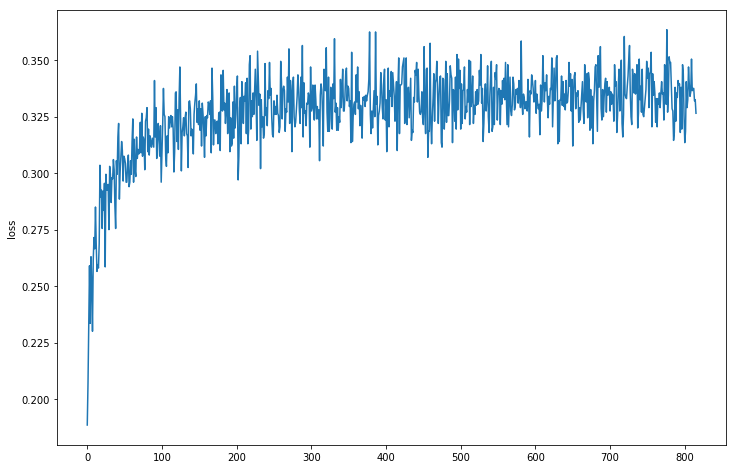

In [198]:
plot_history(acc_history, loss_history,  avg_range=100)

### Validace

Podobně jako trénování, validace je také pokaždé stejný proces, pouze s jinými součástmi. Rovněž ji tedy zabalíme do metody,  které předáme model (tentokrát pouze dopředný průchod) a data, na kterých se má ověřit.

In [199]:
def validate(model, X_data, y_data, print_every=1000):
    """
    Validace modelu
    
    vstup:
        model     ... objekt tridy Layer; musi implementovat metody forward a backward
        X_data    ... N x D matice trenovacich dat
        y_data    ... N vektor labelu (int)
    """
    
    num_correct = 0
    
    for n in range(X_data.shape[0]):   
        # ziskame data (jeden vzorek)
        xn = preprocess(X_data[None, n]).ravel()
        yn = y_data[n]

        # pouze dopredny pruchod
        # pozn.: funkce upravena pro minibatche, ale xn je zde pouze jeden vektor,
        # musime proto pridat jednu dimenzi navic --> minibatch o velikosti 1
        score = model.forward(xn[None, ...])
        
        pred = score.argmax()
        if pred == yn:
            num_correct += 1
        
        # cas od casu vypis, jak se dari
        if (n + 1) % print_every == 0:
            print('{}/{}: acc={:.3f}'.format(n + 1, X_data.shape[0], num_correct / (n + 1)))

    print('val accuracy: {}/{} = {:.1f} %'.format(num_correct, X_data.shape[0], 100. * num_correct / X_data.shape[0]))

In [204]:
%%time
#################################################################
# ZDE DOPLNIT
#################################################################
validate(softmax_model, X_train, y_train, print_every=2000)

2000/40000: acc=0.343
4000/40000: acc=0.343
6000/40000: acc=0.339
8000/40000: acc=0.338
10000/40000: acc=0.340
12000/40000: acc=0.339
14000/40000: acc=0.336
16000/40000: acc=0.334
18000/40000: acc=0.335
20000/40000: acc=0.334
22000/40000: acc=0.335
24000/40000: acc=0.336
26000/40000: acc=0.337
28000/40000: acc=0.337
30000/40000: acc=0.336
32000/40000: acc=0.335
34000/40000: acc=0.335
36000/40000: acc=0.336
38000/40000: acc=0.336
40000/40000: acc=0.336
val accuracy: 13451/40000 = 33.6 %
Wall time: 7.22 s


## Vícevrstvý perceptron

Teď, když máme moduralizovanou lineární vrstvu, můžeme si jich vytvořit více a začít je za sebe řetězit. K tomu, abychom vytvořili vícevrstvou síť, však potřebujeme mezi jednotlivé lineární vrstvy ještě přidat nějakou nelineární aktivační funkci. Více lineárních vrstev za sebou totiž dohromady tvoří stále pouze lineární funkci, byť se specifickou faktorizací parametrů.

Nejjednodušší vícevrstvá síť je dvouvrstvý perceptron (perceptron s jednou skrytou vrstvou). Model je:
1. $s_1 = W_1x + b_1$
2. $h = f(x)$
3. $s_2 = W_2h + b_2$
kde $f$ je nějaká nelinearita.

### Sigmoid funkce

Historicky populární volbou nelinearity vycházející z biologického modelu neuronů je sigmoida. Vypadá následovně:


**dopředný průchod**
$$h = \frac{1}{1 + \exp(-s)}$$

**zpětný průchod**
$$\frac{\partial L}{\partial s} = \frac{\partial L}{\partial h} h (1 - h)$$

In [279]:
class Sigmoid(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, s):
        #################################################################
        # ZDE DOPLNIT
        #################################################################
        h = 1/(1+np.exp(-s))
        self._cache = h
        return h
    
    def backward(self, dh):
        #################################################################
        # ZDE DOPLNIT
        #################################################################
        h = self._cache
        ds = dh*(1-dh)
        return ds, {}

In [280]:
# overime na male davce
s = np.random.randn(10, 5)

# "simulace" prichoziho gradientu, ktery ma vrstva dale propagovat
dh = np.random.randn(10, 5)

# instance vrstvy
sigmoid_layer = Sigmoid()

# jelikoz sigmoida nema zadne parametry, kontrolovat se bude pouze gradient na vstup
check_gradients(sigmoid_layer, s, dh)

ValueError: too many values to unpack (expected 2)

### Definice modelu

In [309]:
class TwoLayerPerceptron(Layer):
    def __init__(self, input_dim, hidden_dim, output_dim, init_coef=1e-4):
        super().__init__()
        
        self.d1 = Dense(input_dim, hidden_dim, init_coef=init_coef)
        self.sigm = Sigmoid()
        self.d2 = Dense(hidden_dim, output_dim, init_coef=init_coef)
        
        self.params = {
            'w1': self.d1.params['w'],
            'b1': self.d1.params['b'],
            'w2': self.d2.params['w'],
            'b2': self.d2.params['b'],
        }
    
    def forward(self, x):
        #################################################################
        # ZDE DOPLNIT
        #################################################################
        w1 = self.d1.params['w']
        b1 = self.d1.params['b']
        
        w2 = self.d2.params['w']
        b2 = self.d2.params['b']
        
        s1 = np.dot(x, w1) + b1
        h = self.sigm.forward(s1)
        s2 = np.dot(h, w2) + b2 
        
        print(x.shape, w1.shape, w2.shape, h.shape)
        self._cache = x ,w1, h, w2
        return s2
    
    def backward(self, ds2):
        #################################################################
        # ZDE DOPLNIT
        #################################################################
        """
        x, w = self._cache
        w = self.params['w'] 
        dx = np.dot(ds,w.T)
        dw = np.dot(x.T,ds)
        db = np.sum(ds, axis=0)
        """
        
        x ,w1, h, w2 = self._cache
        w2 = self.d2.params['w'] 
        #h = self.params['h']
        w1 = self.d1.params['w']
        
        dw2 = np.dot(h.T,ds2)
        db2 = np.sum(ds2, axis=0)
        ds = np.dot(ds2,w2.T)
        
        dh = self.sigm.backward(ds)[0]
        
        #nemohl jsem najit na to funkci
        temp_dh_range = (x.shape[1], dh.shape[0])
        temp_dh = np.zeros(temp_dh_range)
        
        for i in range(0, temp_dh_range[0]):
            temp_dh[i] = dh
        
        #
        dh = temp_dh
        print(x.shape, dw2.shape, ds.shape, dh.shape)
        dw1 = np.dot(x,dh)
        dx = np.dot(dh,w1.T)
        dh = np.sum(dh, axis=0)

        # WTF is this??
        grads = {
            'w1': grads1['w'],
            'b1': grads1['b'],
            'w2': grads2['w'],
            'b2': grads2['b'],
        }
        
        return dx, grads

In [295]:
x = [1,2,3]
x2 =  np.zeros([5, 3])
for i in range(0, 5):
    x2[i] = x
    
print(x2)

[[1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]]


In [310]:
# overime na male davce
x = np.random.randn(20, 10)

# "simulace" prichoziho gradientu, ktery ma vrstva dale propagovat
ds2 = np.random.randn(20, 3)

# instance vrstvy
two_layer_perc = TwoLayerPerceptron(10, 5, 3)

# jelikoz sigmoida nema zadne parametry, kontrolovat se bude pouze gradient na vstup
check_gradients(two_layer_perc, x, ds2)

(20, 10) (10, 5) (5, 3) (20, 5)
(20, 10) (5, 3) (20, 5) (10, 5)


NameError: name 'grads1' is not defined

### Inicializace

In [ ]:
x_dim = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]
hidden_dim = 200

two_layer_perc = TwoLayerPerceptron(x_dim, hidden_dim, len(classes))

loss_history = []
l2_history = []
acc_history = []

### Trénování

In [ ]:
%%time
#################################################################
# ZDE DOPLNIT
#################################################################
for ep in range(...):
    train_sgd(...)

In [ ]:
plot_history(loss_history, acc_history, avg_range=100)

### Validace

In [ ]:
%%time
#################################################################
# ZDE DOPLNIT
#################################################################
validate(...)

## Konfigurovatelný model vícevrstvého perceptronu

### ReLU nelinearita

V současnosti je jednou z nejpopulárnějších nelinearit ReLU. Má podobu:

**dopředný průchod**
$$h = \max(0, s)$$

**zpětný průchod**
$$\frac{\partial L}{\partial s} = \frac{\partial L}{\partial h} \boldsymbol{1}(s \ge 0)$$

In [ ]:
class ReLU(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, s):
        self._cache = s.copy(),
        return np.maximum(0., s)
    
    def backward(self, dh):
        s, = self._cache
        ds = dh.copy()
        ds[s <= 0.] = 0.
        return ds, {}

#### Gradient check

Jelikoz ReLU není diferencovatelná, nemusí si numerický a analytický gradient vždy odpovídat. Chyba vznikne, pokud je ve vstupu $s$ nějaká hodnota blíže nule než je krok $\Delta_s$ pro numerickou diferenci. Např. centrální diference v bodě 0.001 s krokem 0.01 je
$$\frac{ReLU(0.001 + 0.01) - ReLU(0.001 - 0.01)}{2\cdot 0.01} = \frac{0.011 - 0}{0.02} = 0.55$$
zatímco analyticky je derivace v bodě $0.001$ rovna přesně $1$. Je tedy možné, že se občas objeví velká rel. odchylka gradientů, mnohem častěji pro malé hodnoty vstupu $s$. Napravit to lze např. menším krokem $\Delta_s$ numerické diference, který by měl být řádově menší než vstup $s$.

In [ ]:
# overime na male davce
s = np.random.randn(10, 5)

# "simulace" prichoziho gradientu, ktery ma vrstva dale propagovat
dh = np.random.randn(10, 5)

relu = ReLU()
check_gradients(relu, s, dh)

### Definice modelu

In [ ]:
class FeedForwardNet(Layer):
    def __init__(self, layers):
        super().__init__()
        
        self.layers = layers
        
        self.params = {}
        for i, layer in enumerate(layers):
            for name, par in layer.params.items():
                self.params[name + str(i)] = par
    
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, dx):
        model_grads = {}
        
        for i, layer in reversed(list(enumerate(self.layers))):
            dx, layer_grads = layer.backward(dx)
            
            for name, dpar in layer_grads.items():
                model_grads[name + str(i)] = dpar
        
        return dx, model_grads

In [ ]:
# gradient check

# overime na male davce
x = np.random.randn(20, 15)

# "simulace" prichoziho gradientu, ktery ma vrstva dale propagovat
dout = np.random.randn(20, 5)

layers = [
    Dense(15, 10),
    Sigmoid(),
    Dense(10, 8),
    ReLU(),
    Dense(8, 5),
]
feed_forward_net = FeedForwardNet(layers)
check_gradients(feed_forward_net, x, dout)

### BONUS: Trénování

Natrénujte co nejlepší model!

In [ ]:
#################################################################
# ZDE JE PROSTOR PRO VASI KREATIVITU
#################################################################